In [1]:
from query.datasets.prelude import *
from query.datasets.tvnews.report import *

NETWORK_COLORS = [
    ('CNN', 'tab:blue'),
    ('FOXNEWS', 'tab:orange'),
    ('MSNBC', 'tab:green')
]

# Introduction
In the news, everyone's got an opinion, and everyone also has an opinion about the news. This channel is biased, that show only talks about negative news, the whole media covers too much Trump. Opinions are easy to make based on the individuals shows and clips we watch or see shared on social media every day. Therefore, now more than ever, it's critical that our understanding of how we produce and consume news is informed by data, not anecdotes.

At the same time, advances in artificial intelligence and big data systems are now enabling us to analyze complex visual mediums like video at scale. Computer vision and machine learning technologies can automatically watch video to find and recognize individuals, identify visual attributes like clothing, lighting, and setting, as well as break video into segments, e.g. commercials vs. news. Cloud infrastructure combined with big data systems can enable small groups to scale these technologies to automatically annotate thousands or millions of hours of video.

In this study, we analyzed 70,000 hours of US TV news video provided by the Internet Archive to identify trends in screen time, speaking time, clothing, and more with a focus on gender bias. Our dataset specifically consisted of every video broadcast by CNN, FOX, and MSNBC since January 1, 2015, and included the video, audio, and closed captions. Methodology for each analysis is provided at the end of this report.

# Gender bias
Most of the news is anchors and guests staring into the camera, discussing the topics of the day with one another (or in monologue). Here, we are interested in understanding who is being provided the platform to share their views, along with when/where that occurs. We computed two metrics: screen time, or the length of time a person is on screen, and speaking time, or how long a person is talking in the audio stream. For example, if two men and one woman are on screen for 5 seconds with the woman speaking, this would be 10 seconds of male screen time, 5 seconds of female screen time, and 5 seconds of female speaking time. We then look at the percentage of total time that anyone was on screen or anyone was talking to determine the fraction of men vs. women.

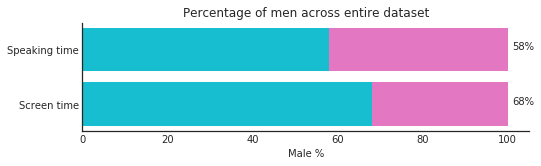

In [2]:
screen_df = pd.DataFrame.from_csv('/app/data/screen_all.csv')
speak_df = pd.DataFrame.from_csv('/app/data/speaking_all.csv')
X = [0, 1]
Y1 = [screen_df['M%'][0], speak_df['M%'][0]]
Y2 = [100 - n for n in Y1]
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
plt.title('Percentage of men across entire dataset')
plt.barh(X, Y1, color='tab:cyan')
plt.barh(X, Y2, color='tab:pink', left=Y1)
plt.yticks(X, ['Screen time', 'Speaking time'])
plt.xlabel('Male %')
ax.annotate('{}%'.format(Y1[1]), [101, 1])
_ = ax.annotate('{}%'.format(Y1[0]), [101, 0])

Across the whole dataset, we found that there were about twice as many men as women shown on screen, and a similar but slightly more equal balance for speaking time (shown above). This is roughly consistent with a previous finding of the same bias in [feature films](https://www.google.com/about/main/gender-equality-films/). There were no significant differences between the channels (FOX/CNN/MSNBC), however we did find substantial variance in individual shows.

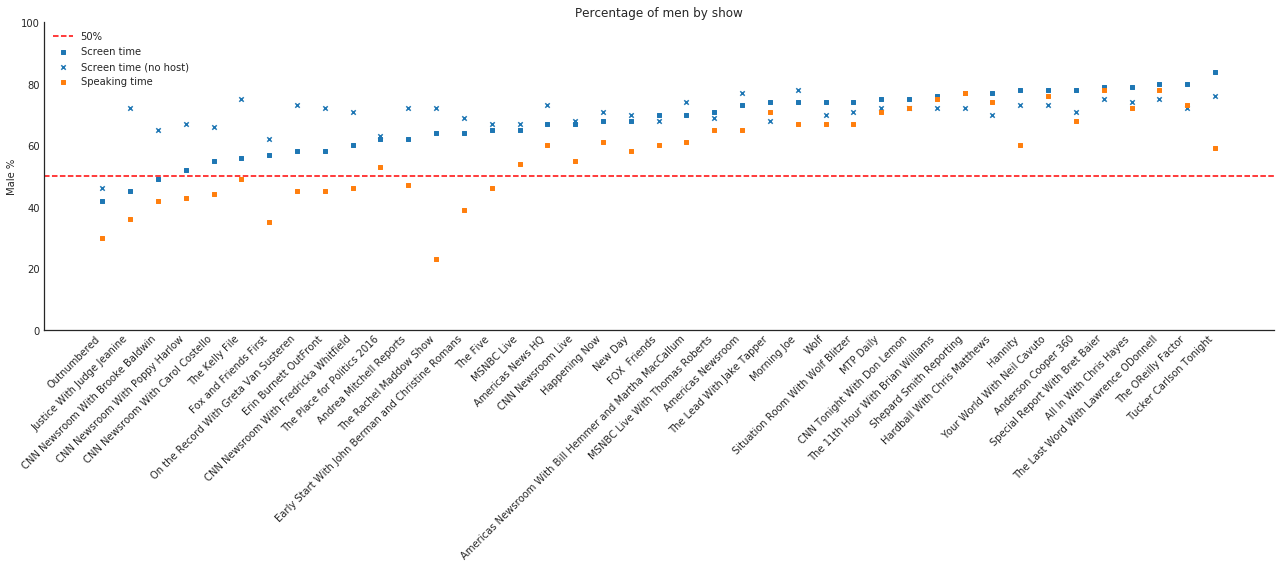

In [15]:
screen_show = pd.DataFrame.from_csv('/app/data/screen_show.csv')
screen_show_nh = pd.DataFrame.from_csv('/app/data/screen_show_nh.csv')
speaking_show = pd.DataFrame.from_csv('/app/data/speaking_show.csv')
speaking_show_nh = pd.DataFrame.from_csv('/app/data/speaking_show_nh.csv')
screen_speak_scatter(screen_show, screen_show_nh, speaking_show, speaking_show_nh, 'show_id', 'show')

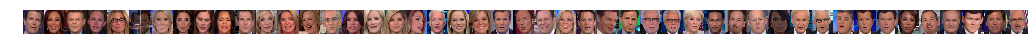

In [17]:
shows = screen_show.sort_values(by=['M%']).show_id

def get_face(show):
    host_face = Face.objects.filter(is_host=True, person__frame__video__show__name=show) \
        .select_related('person__frame__video')[0]
    return resize(crop(load_frame(host_face.person.frame.video, host_face.person.frame.number, []), host_face), None, 50)

faces = par_for(get_face, shows, progress=False)

#plt.imshow(cv2.cvtColor(np.vstack((np.hstack(faces[:len(faces)/2]), np.hstack(faces[len(faces)/2:]))), cv2.COLOR_RGB2BGR))
plt.imshow(cv2.cvtColor(np.hstack(faces), cv2.COLOR_RGB2BGR))
_ = plt.axis('off')

Above, we plot the top 30 shows by airtime with their percentage of men vs. women for screen time (blue) and speaking time (orange), sorted by the screen time from most women to most men. We have two marker shapes, one for percentage including the host (square) and one for without the host (cross). A few interesting observations emerge:
* As expected, female-hosted shows like The Kelly File and The Rachel Maddow Show have more female screen/speaking time. Mixed-host shows like The Five and FOX & Friends are towards the middle, and male-hosted shows have more men.
* Only a single show in the top 30 (CNN Newsroom with Brooke Baldwin) has a higher percentage of women on screen than men.
* While most shows have roughly similar screen and speaking time distributions, a few shows have substantially more female speaking time than screen time, e.g. The Rachel Maddow Show, Hannity, and Tucker Carlson Tonight. 
* 


**TODO: robustly generate host face montage.**<br />
**TODO: compute robust audio statistics without the host.**

We would also like to know what people are talking about, and how that differs based on gender. Using the transcripts, we selected a representative topic for each segment of the video (drawn from the [US News topic list](https://www.usnews.com/topics/subjects)), and then looked at who was talking/on screen during each kind of segment.

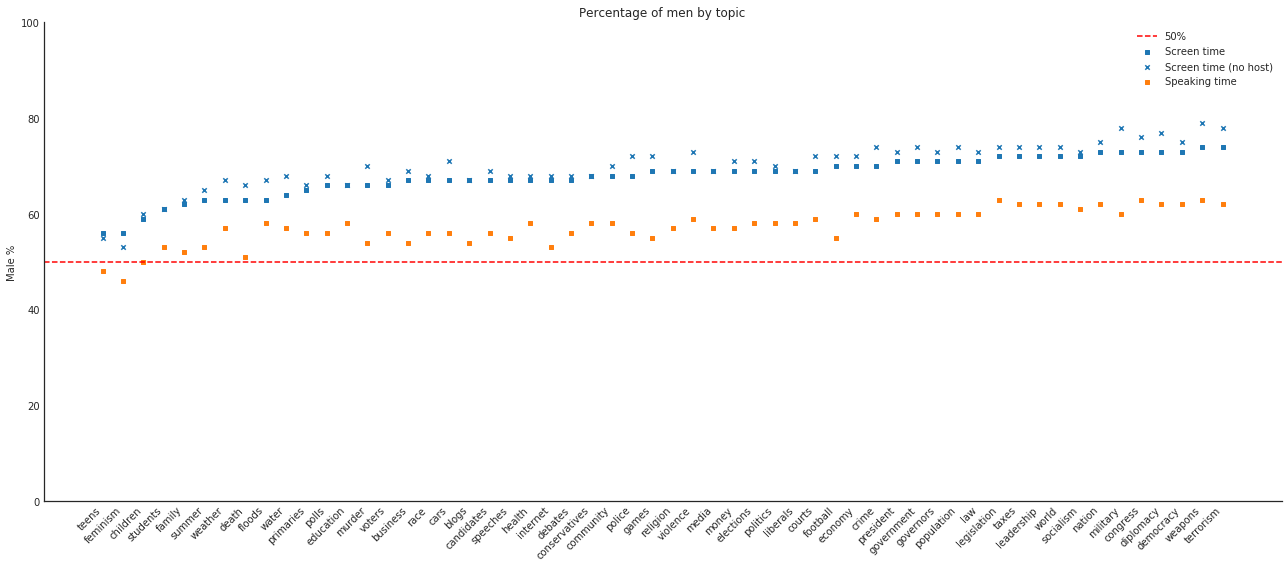

In [5]:
screen_speak_scatter(
    pd.DataFrame.from_csv('/app/data/screen_topic.csv'),
    pd.DataFrame.from_csv('/app/data/screen_topic_nh.csv'),
    pd.DataFrame.from_csv('/app/data/speaking_topic.csv'),
    pd.DataFrame.from_csv('/app/data/speaking_topic_nh.csv'),
    'topic', 'topic')

The graph above shows the top 60 topics by screen time, plotted in the same fashion as the previous figure. A clear trend emerges: women speak about more feminine topics, and men speak about more masculine topics. More women speak about feminism, family, and education, while more men speak about congress, terrorism, and the economy. This suggests that male anchors and guests are provided more opportunities to discuss serious topics whereas women primarily discuss lighter topics. One notable exception is that death and murder are surprisingly gender equal.

We also analyzed potential gender disparities in screen/speaking time across days of the week and across the time of day, but found no significant trends, i.e. each day of the week and time of day roughly tracked the overall gender distribution. This suggests that although the news is overall biased, women are not comparatively worse off during prime time hours.

# Topic coverage
With the abolition of the Fairness Doctrine in 1987 shortly preceding the rise of cable news, it has been a well documented phenomenon that today's news networks are more polarized than ever before. Consuming media from a single network presents a very particular view of the world, but we'd like to quantify the extent to which different networks cover different people, events, and topics. One perspective on this asks, given the same topic like gun control, what viewpoints do the networks have and how do they promote them? This requires a nuanced understanding of the language used, so we instead look at a simpler question: who is covering particular topics, people, and phrases and for how long?

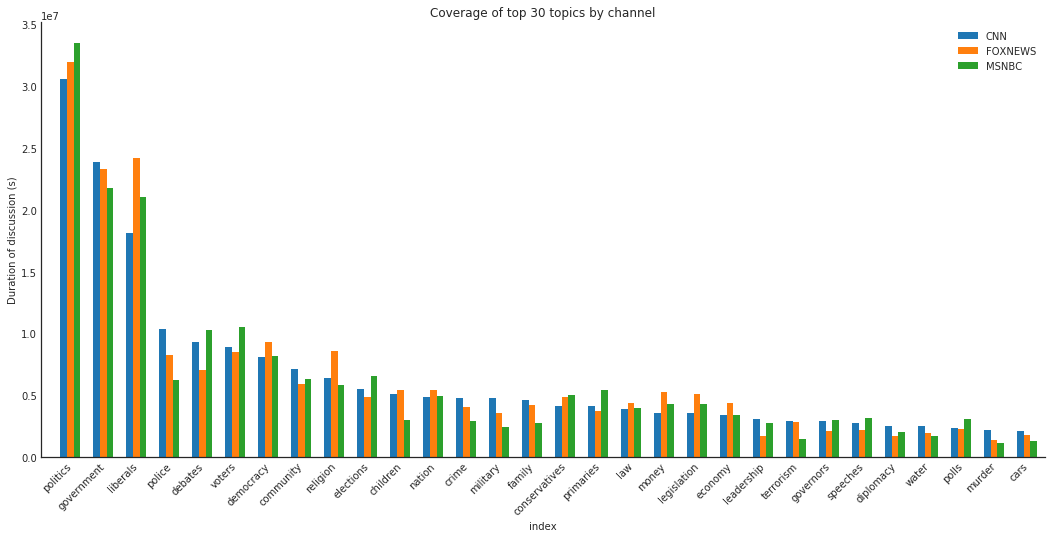

In [6]:
topic_channel_dfs = pickle.load(open('/app/data/topic_channel.pkl', 'rb'))
topic_channel = topic_channel_dfs['duration']

def topic_bar(df, label):
    df = df.sort_values(by=['CNN'], ascending=False).reset_index().head(30)
    ax = plt.gca()
    for i, (network, col) in enumerate(NETWORK_COLORS):
        df.plot.bar('index', network, ax=ax, position=2-i, color=col, width=0.2)
    ax.set_xticks([-1] + range(len(df['index'])))
    ax.set_xticklabels([''] + list(df['index']), rotation=45, horizontalalignment='right')
    ax.set_ylabel('Duration of discussion (s)')
    _ = ax.set_title('Coverage of top 30 {} by channel'.format(label))
    
topic_bar(topic_channel, 'topics')

The above graph shows the length of time provided by each network to covering the 30 most popular topics (note that they are not mutually exclusive, e.g. a piece on liberal voters will likely count for politics, liberals, and voters). From this, we observe:
* The most common topics are political, which is expected both due to the inherently political nature of the networks and the coverage of the 2016 presidential election.
* Fox provides notably greater coverage of liberals and religion than the other two networks.
* MSNBC focuses far more on politics in that it has less coverage of children, crime, family, terrorism, etc. but more coverage of voters, elections, conservatives, and primaries.

We can break this further down by show to identify specific individuals/segments that are likely to cover individual topics.

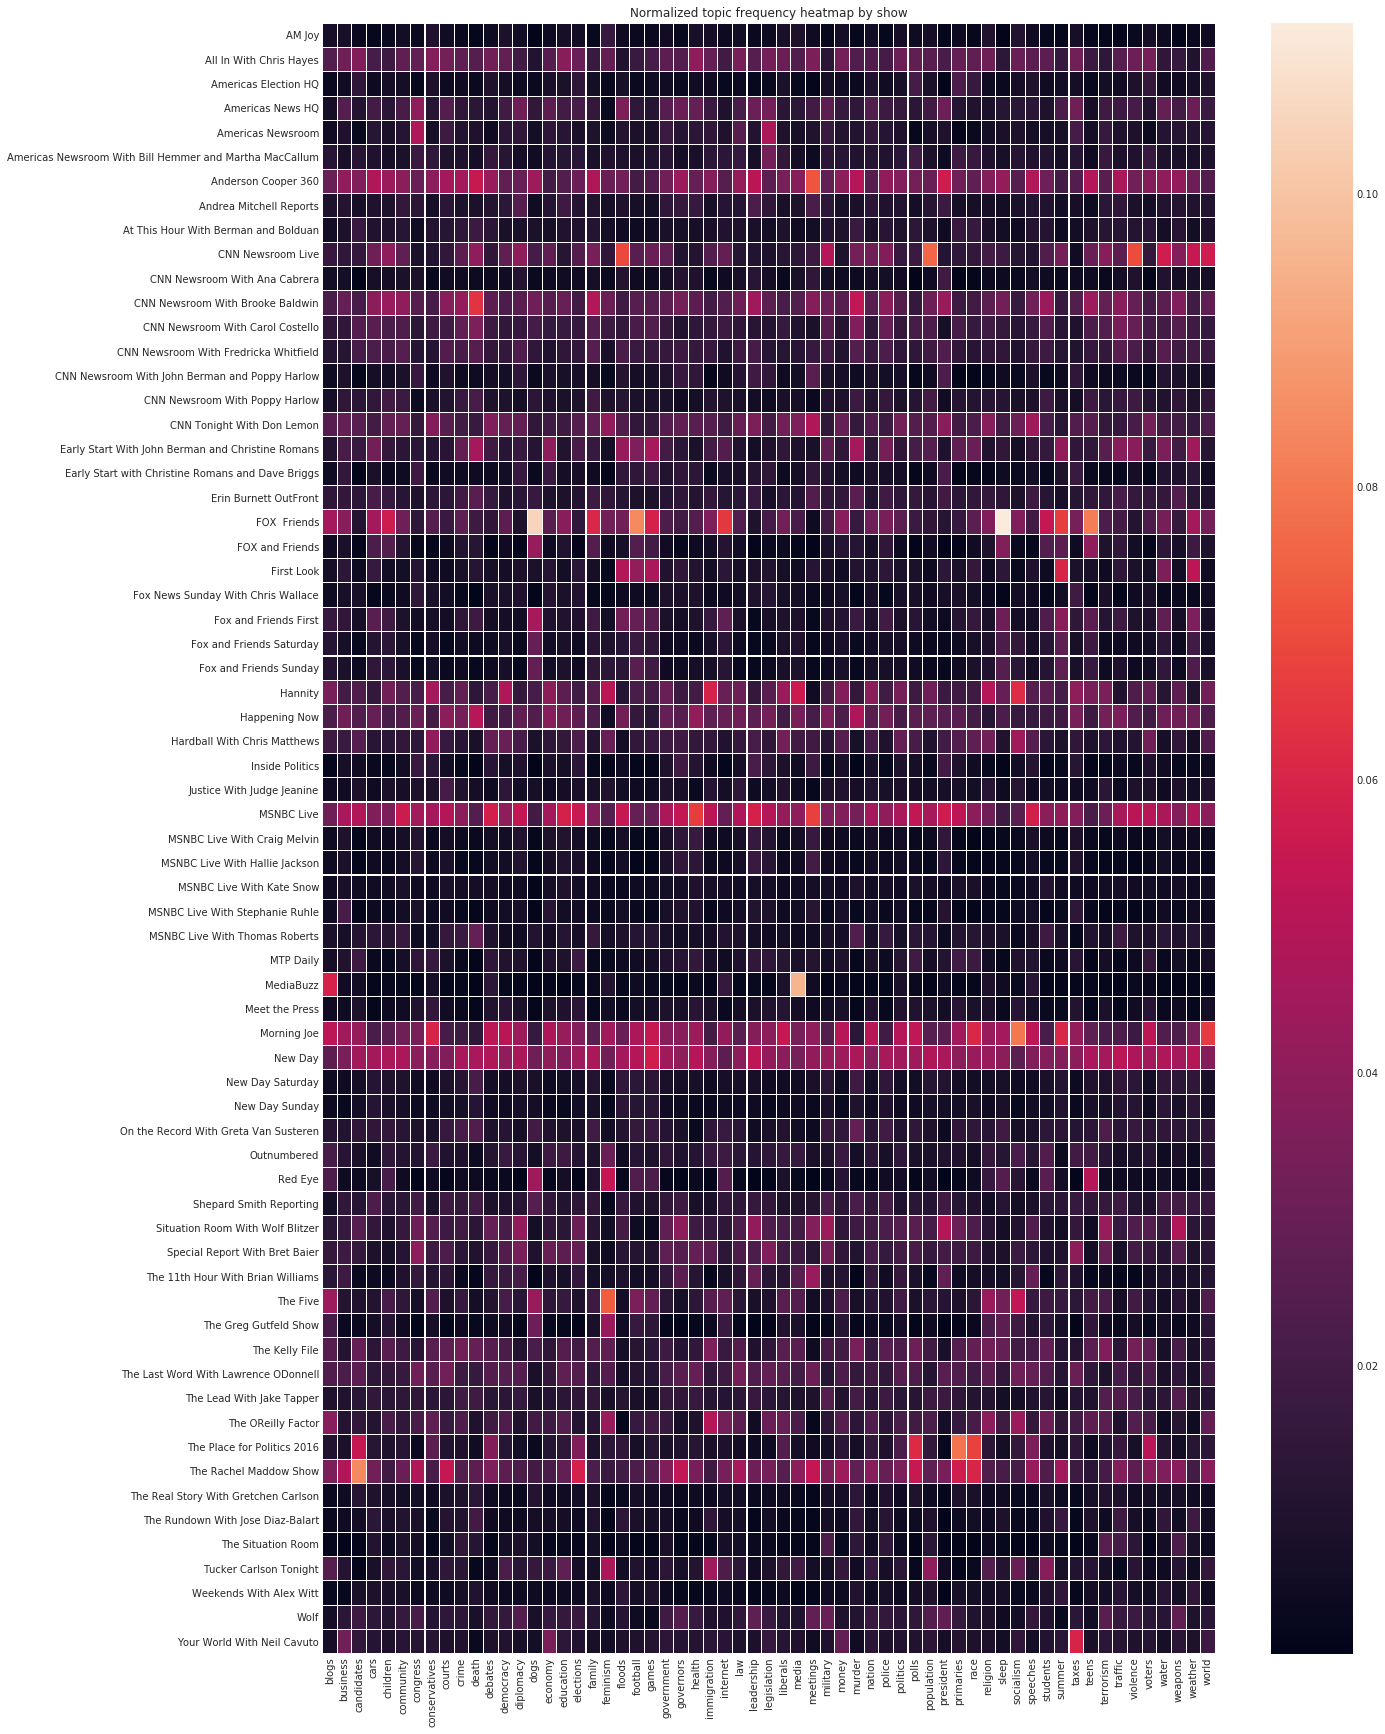

In [7]:
topic_show = pd.DataFrame.from_csv('/app/data/topic_show.csv')

def topic_heatmap(df, label, topic_threshold=2000000, key_threshold=3000000):
    sums = df.sum(axis=1)
    df = df.drop(sums[sums < topic_threshold].index).transpose()
    sums = df.sum(axis=1)
    df = df.drop(sums[sums < key_threshold].index)
    for c in df:
        df[c] /= df[c].sum()
    df = df.fillna(0).transpose()

    fig, ax = plt.subplots(figsize=(20,30))
    sns.heatmap(df.transpose(), xticklabels=True, yticklabels=True, ax=ax, linewidths=0.1)
    _ = plt.title('Normalized {} frequency heatmap by show'.format(label))
    
topic_heatmap(topic_show, 'topic')

The above heatmap shows normalized topic coverage scores, e.g. if Rachel Maddow covers immigration for 6 minutes and Sean Hannity covers it for 4 minutes, then they would receive a normalized score of 0.6 and 0.4, respectively, in the immigration column. Certain shows which appear more frequently than others are identified by clear colorful lines (e.g. MSNBC Live, Anderson Cooper 360). Bright squares indicates that a particular show covers a particular topic more than other shows for the same topic. For example, we can see:
* Rachel Maddow covers almost exclusively election issues (candidates, elections, polls, primaries).
* Fox & Friends is the only show that tends to cover more general interest topics (children, dogs, family, football, games, sleep, summer).
* CNN Newsroom with Brooke Baldwin covers an unusual amount of death.

We can further specialize these topics by looking at the mention of individual people and phrases.

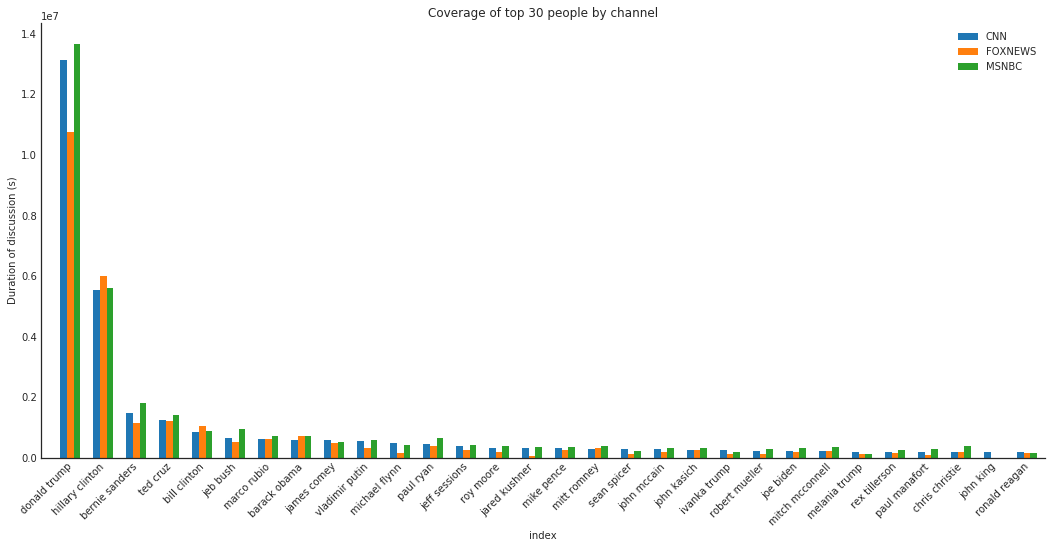

In [8]:
person_channel = pd.DataFrame.from_csv('/app/data/person_channel.csv')
topic_bar(person_channel, 'people')

The above graph is the same as before, except looks at coverage of people instead of topics. We observe:
* Donald Trump was mentioned more than every other individual combined. 
* Trump was provided notably greater coverage on both CNN and MSNBC than Fox. 
* By contrast, Hillary Clinton, Bill Clinton, and Barack Obama received slightly more coverage on Fox.
* Controversial individuals in the Trump Administration like Michael Flynn, Jared Kushner, and Paul Manafort received substantially more coverage from CNN and MSNBC than Fox.

Again breaking down by show:

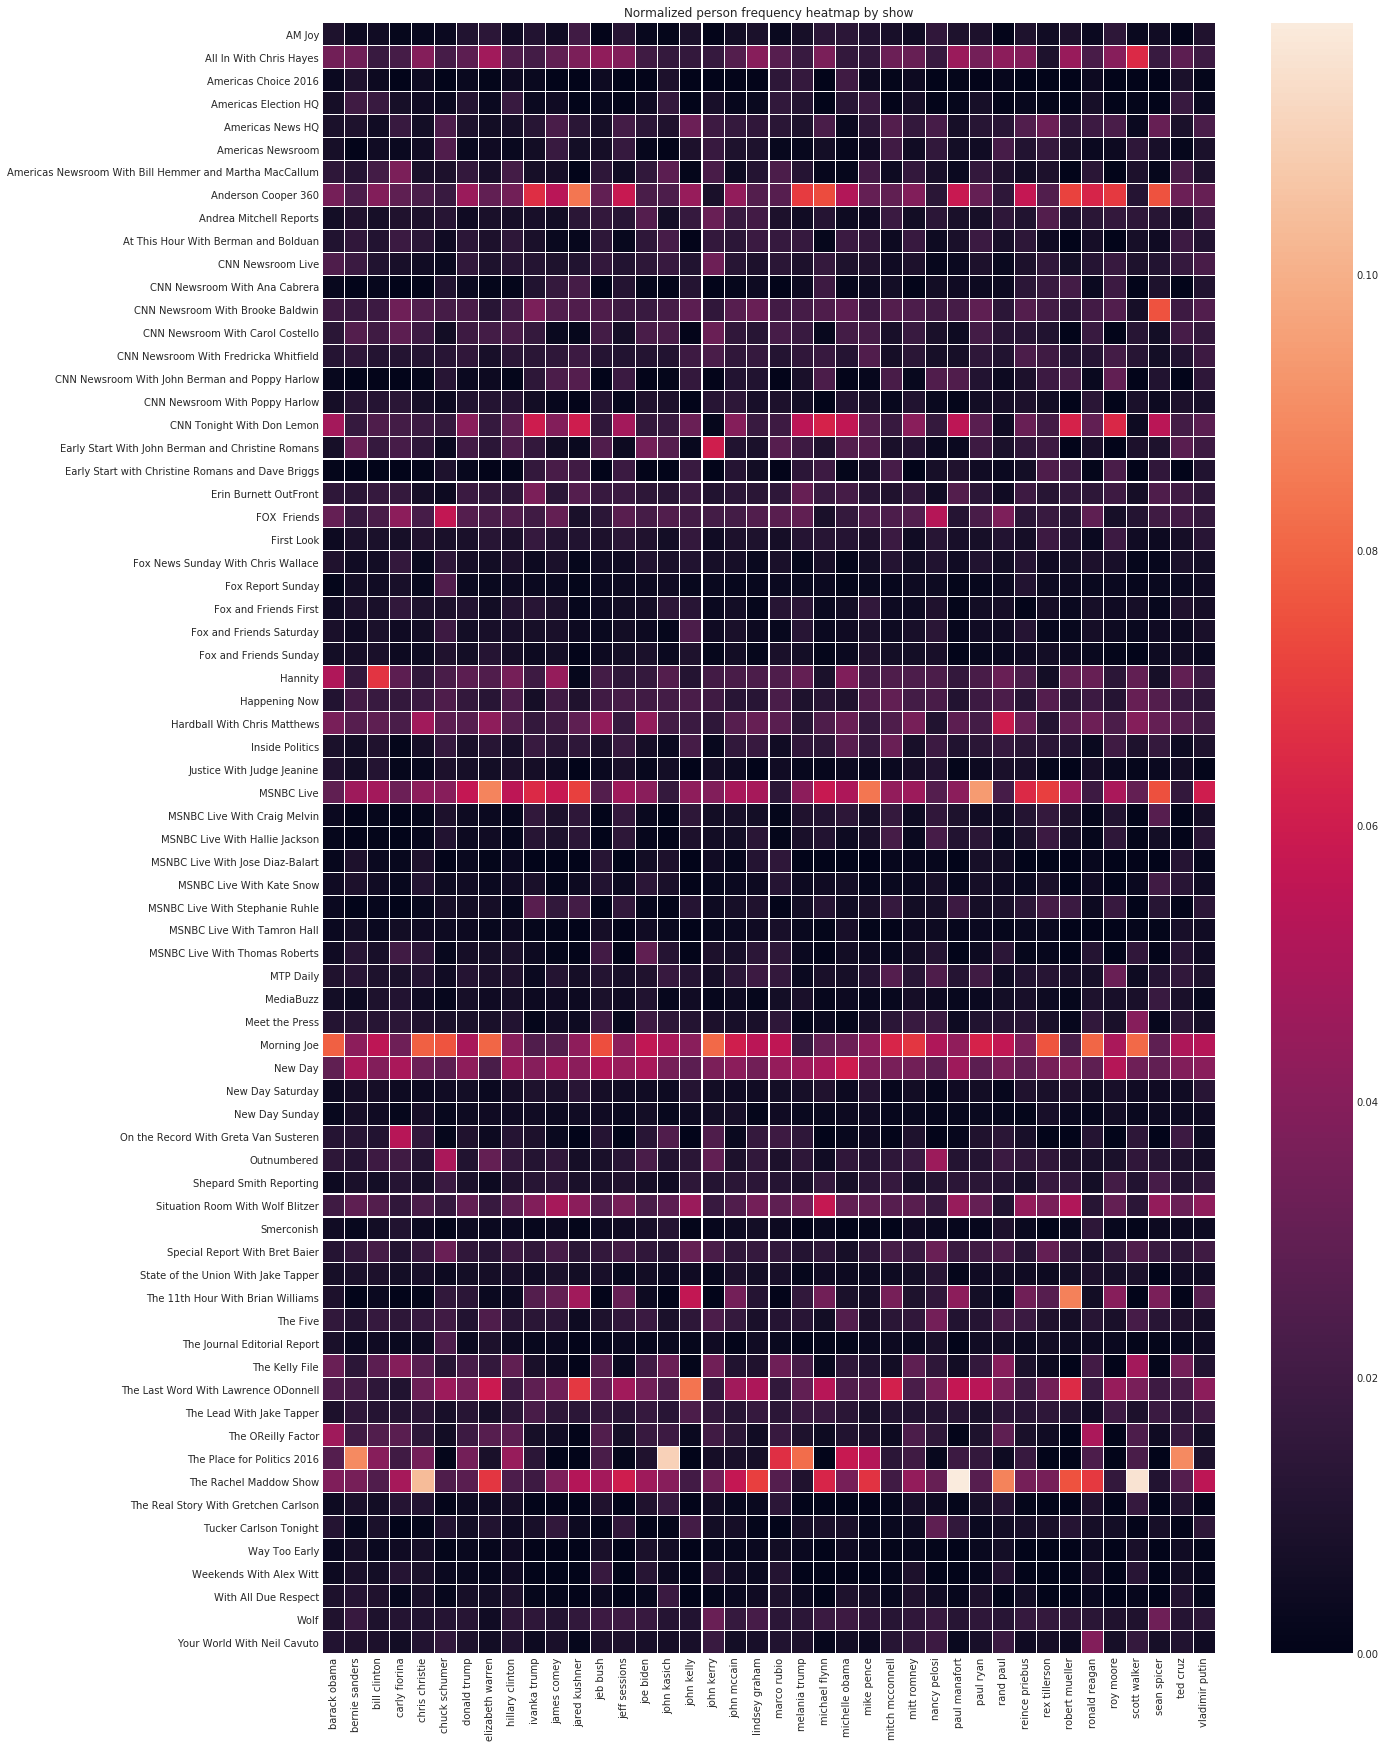

In [9]:
person_show = pd.DataFrame.from_csv('/app/data/person_show.csv')
topic_heatmap(person_show, 'person', topic_threshold=300000, key_threshold=300000)

We can observe that:
* Fox & Friends provided little coverage of anyone in particular except for Chuck Schumer and Nancy Pelosi.
* Rachel Maddow provided unusually high coverage of individuals like Chris Christie, Paul Manafort, and Scott Walker.

Lastly, we can look at the usage of individual phrases.

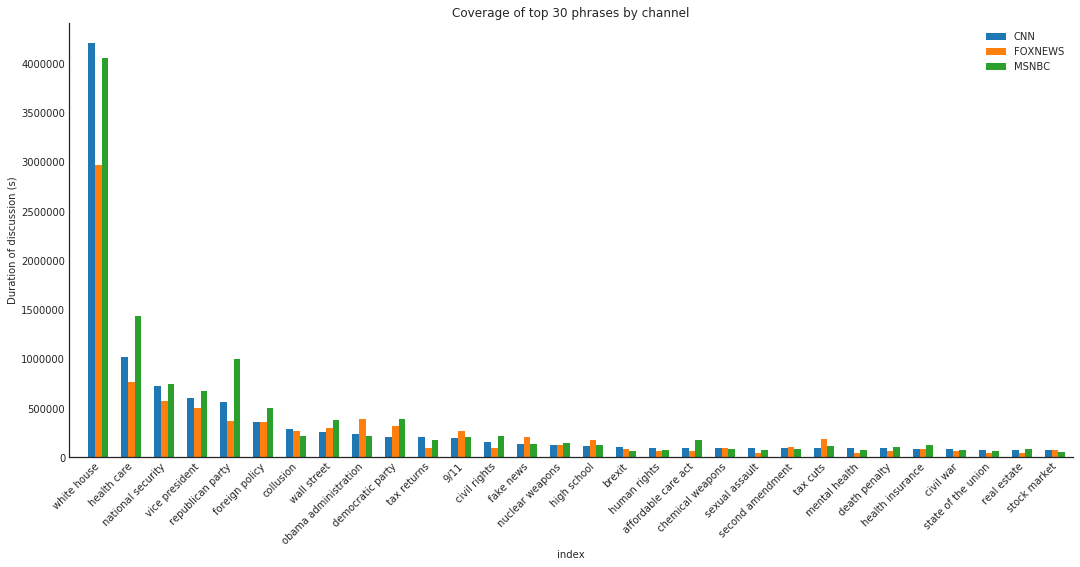

In [10]:
phrase_channel = pd.DataFrame.from_csv('/app/data/phrase_channel.csv')
topic_bar(phrase_channel, 'phrases')

MSNBC focus substantially on health care (including the Affordable Care Act). Fox covered the Obama Administration, fake news, and tax cuts. CNN has no particular outlying behavior.

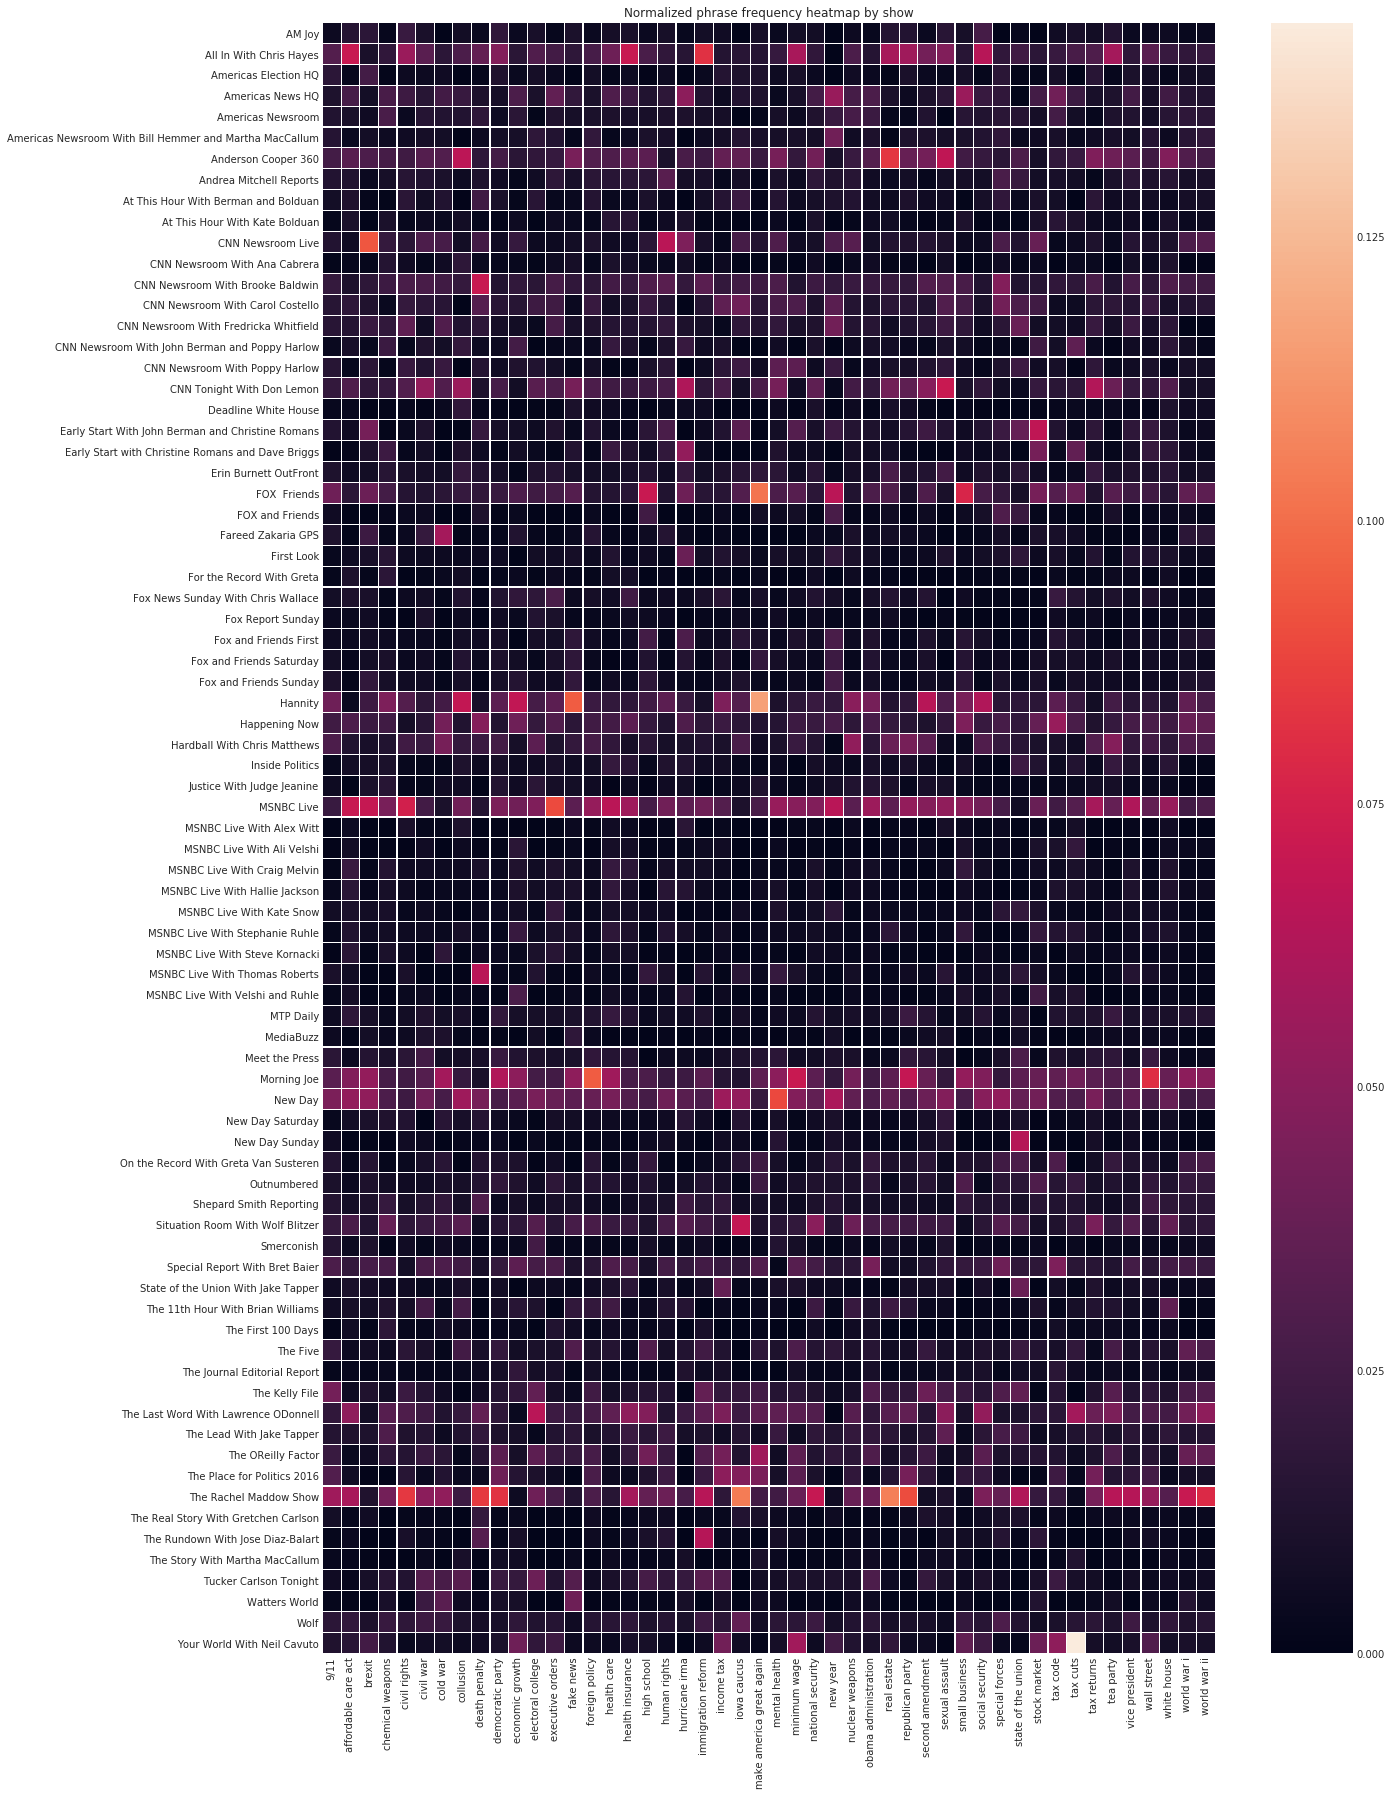

In [11]:
phrase_show = pd.DataFrame.from_csv('/app/data/phrase_show.csv')
topic_heatmap(phrase_show, 'phrase', key_threshold=100000, topic_threshold=100000)

Some notable trends:
* The "Make America Great Again" catchphrase occurs the most frequently on Fox & Friends and Hannity. Similarly, Hannity is the sole major user of "fake news."
* Both Anderson Cooper and Hannity focus on "collusion," however presumably two sides of the same case.
* Morning Joe is the only show to focus on "Wall Street."
* Fox & Friends is the only show to focus on "small business."
* Chris Hayes focuses on mostly serious topics including "health care" and "immigration reform."

Overall, these analyses support the conclusion that there is indeed a disparity of coverage in topics between shows. No individual show or even channel will cover all topics. Bias in topic coverage largely tracks the political leanings of the respective channels and shows. 

# Clothing
On a lighter note, we analyzed the clothing styles of anchors on each show, e.g. what kind of clothing they wear (shirt, dress, suit), what color they wear (necktie, hair, clothing), how long the hair is, and so on. We can visualize these clothing attributes by averaging together every image of hosts with those attributes:

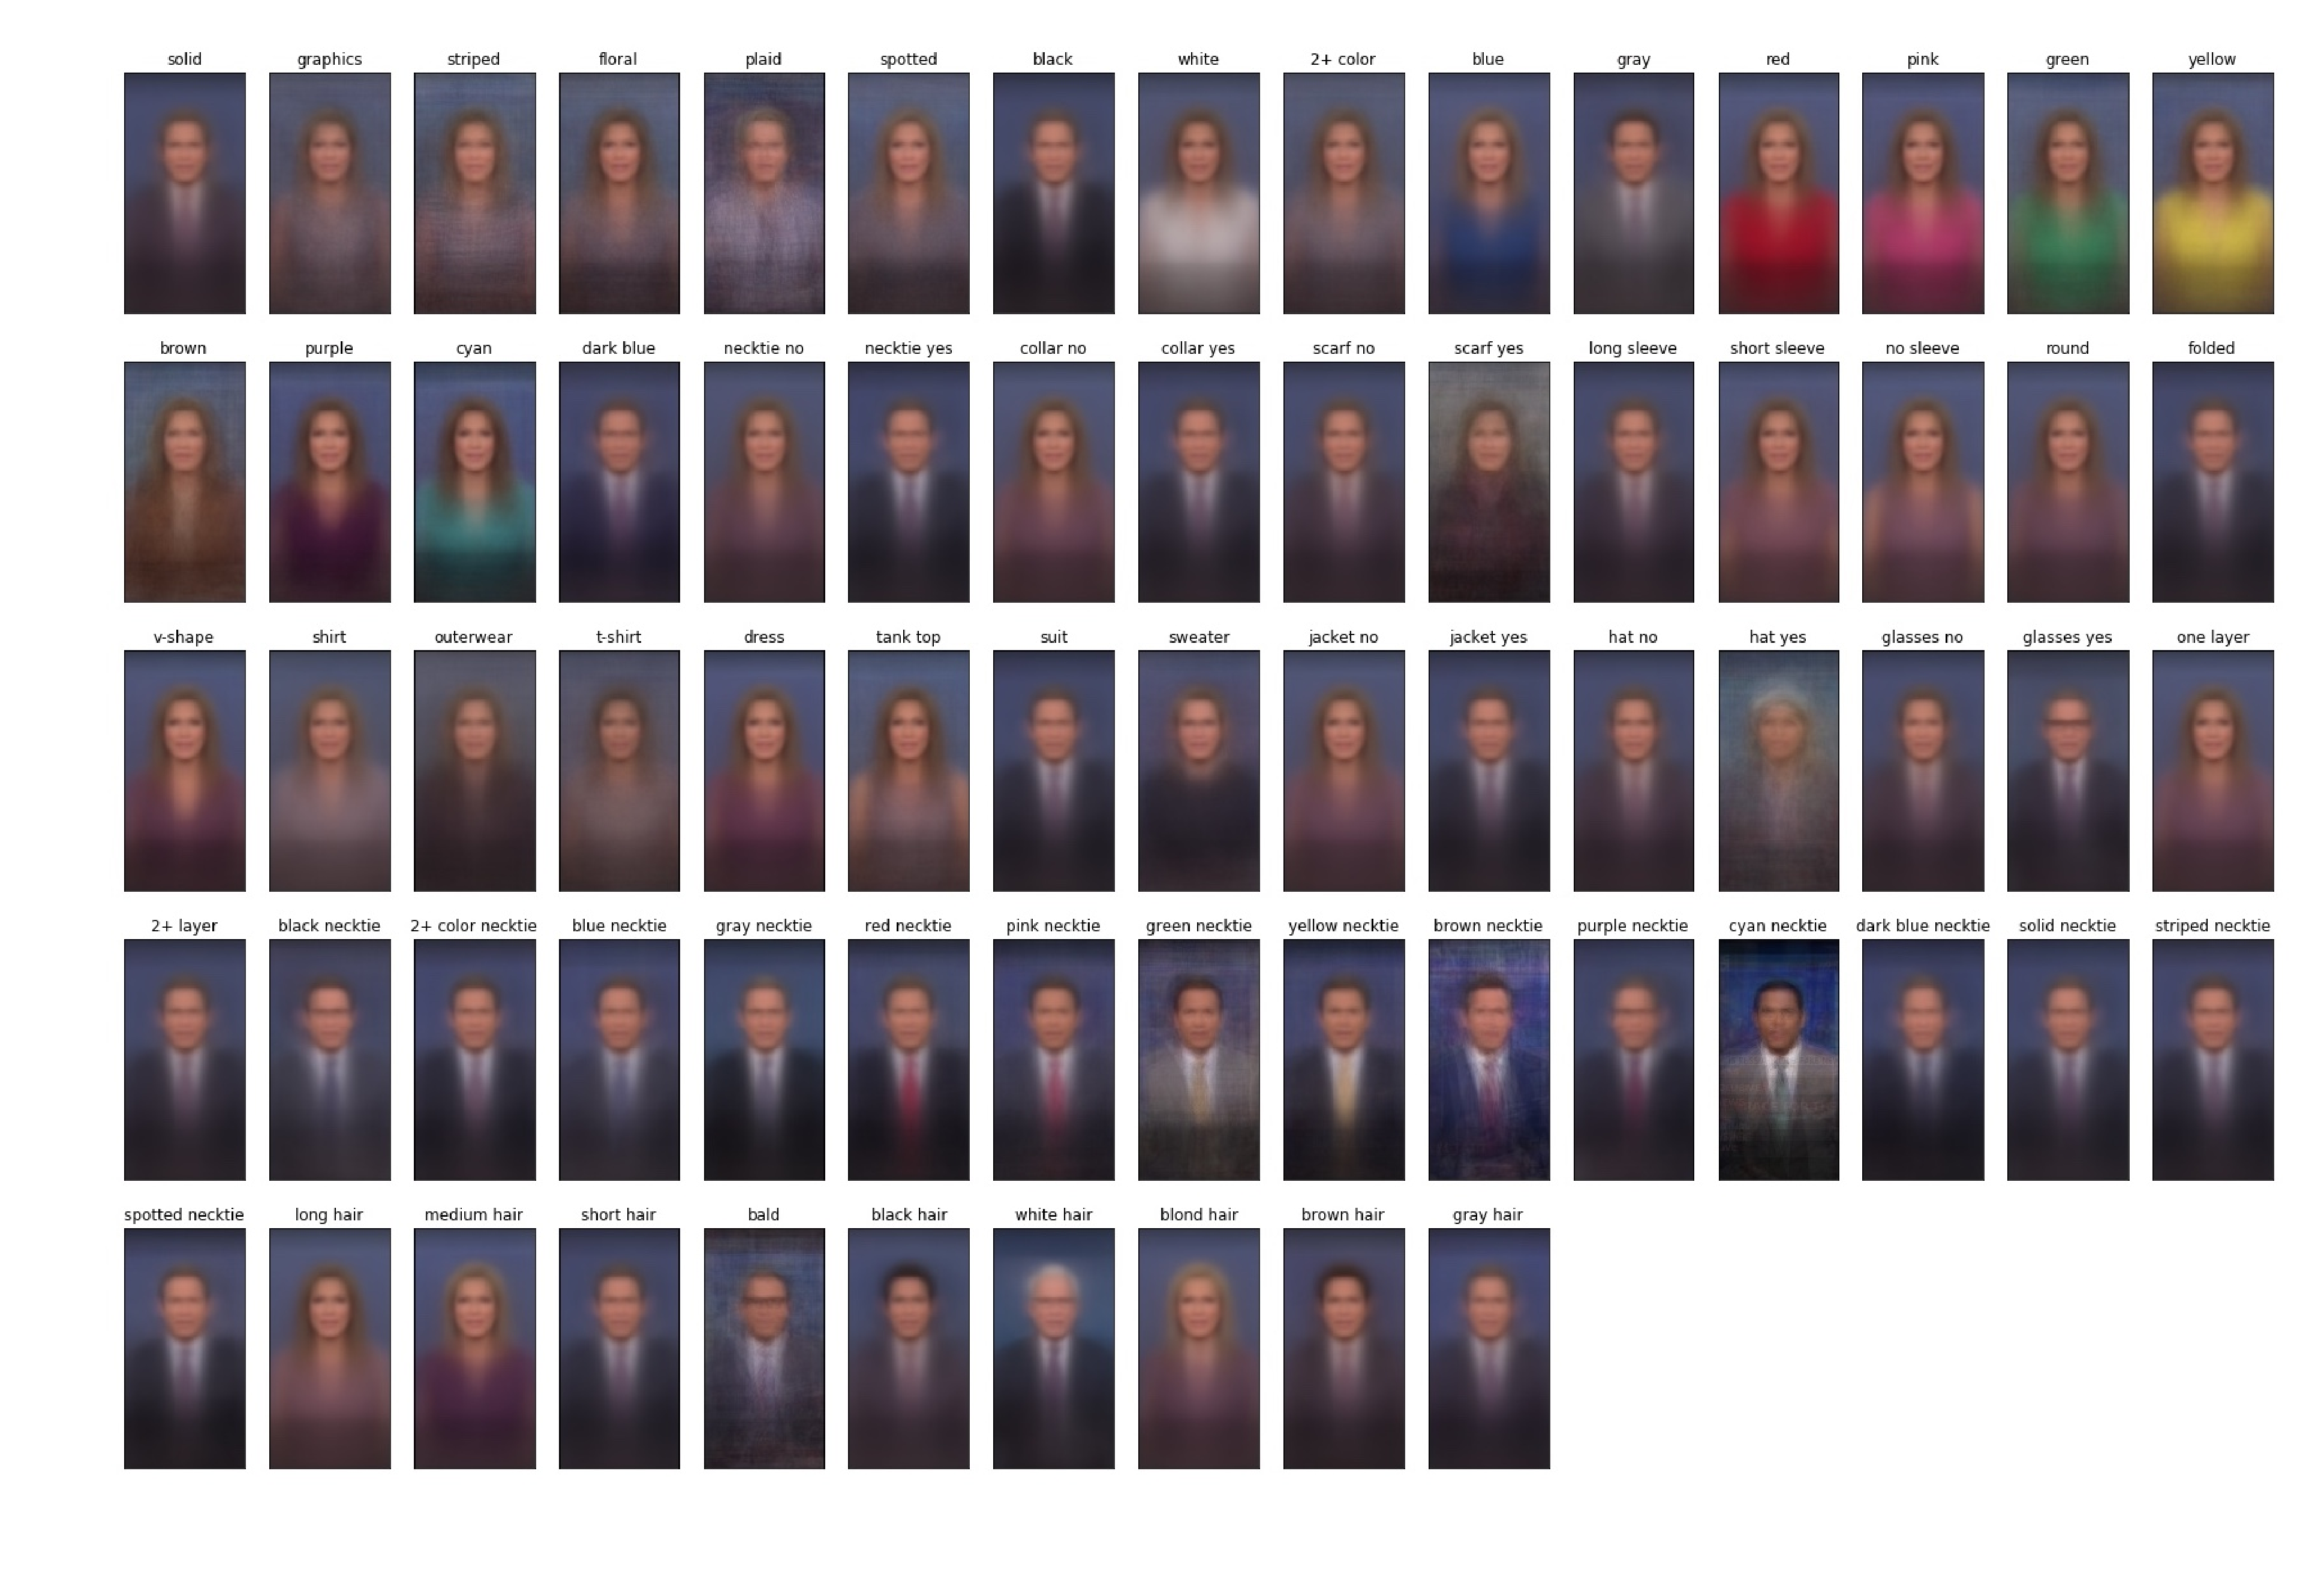

In [12]:
def imshow(path):
    img = cv2.imread(path)
    plt.figure(figsize=(img.shape[1]/100,img.shape[0]/100), dpi=300)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.axis('off')
    
imshow('/app/data/anchor_average.jpg')

These images can confirm basic intuition like women are more likely to wear solid/bright color, men mostly wear suits, and the average person in nearly every category is Caucasian. We can dive deeper into individual clothing trends by looking across time.

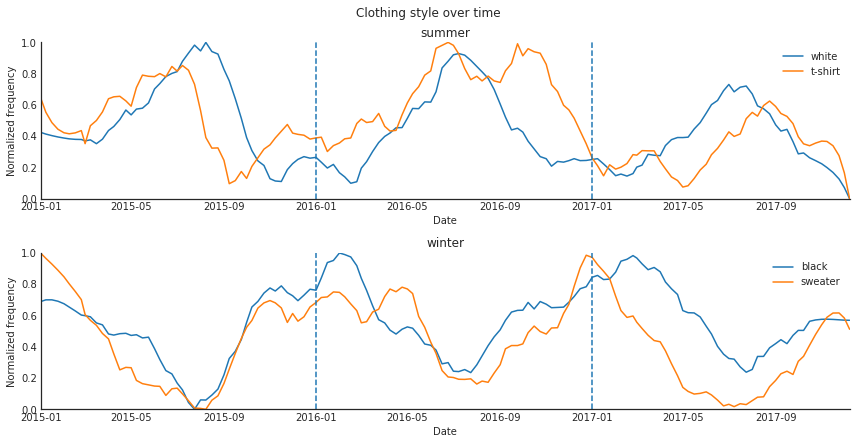

In [13]:
df = pickle.load(open('/app/data/clothing_color_time.pkl', 'rb'))
df2 = pickle.load(open('/app/data/clothing_style_time.pkl', 'rb'))
df = pd.concat([df, df2], axis=1)
for col in df.columns:
    cmin, cmax = (df[col].min(), df[col].max())
    if cmax - cmin > 0:
        df[col] = (df[col] - cmin) / (cmax - cmin)
df['date'] = df.index

def clothing_time_plot(styles):
    plt.figure(figsize=(12, 6))
    plt.suptitle('Clothing style over time', y=1.02)
    for plotidx, (stylename, styleset) in enumerate(styles):
        year_dates = [df.date[48], df.date[96]]
        plt.subplot(len(styles), 1, plotidx+1)    
        ax = plt.gca()
        for style in styleset:
            df.plot('date', style, ax=ax)
        ax.set_ylim(0, 1)
        ax.axvline(x=year_dates[0], linestyle='--')
        ax.axvline(x=year_dates[1], linestyle='--')
        ax.set_title(stylename)
        ax.set_xlabel('Date')
        ax.set_ylabel('Normalized frequency')
        ax.legend(loc='upper right')
    plt.tight_layout()
    
clothing_time_plot([('summer', ('white', 't-shirt')), ('winter', ('black', 'sweater'))])

The above graph shows the normalized frequency of occurrence for when all hosts wear certain styles of clothes. Normalized means 1 is when people are wearing the clothes most often, and 0 the least--it does not imply how often these styles occur relative to one another. Here, we can see that our anchors clearly follow documented seasonal trends, i.e. they are more likely to wear lighter colors (white) and clothing (t-shirt) in the summer, and more likely to wear darker colors (black) and heavier clothing (sweaters) in the winter. We can then separate these trends out across channels to find differences in clothing preference:

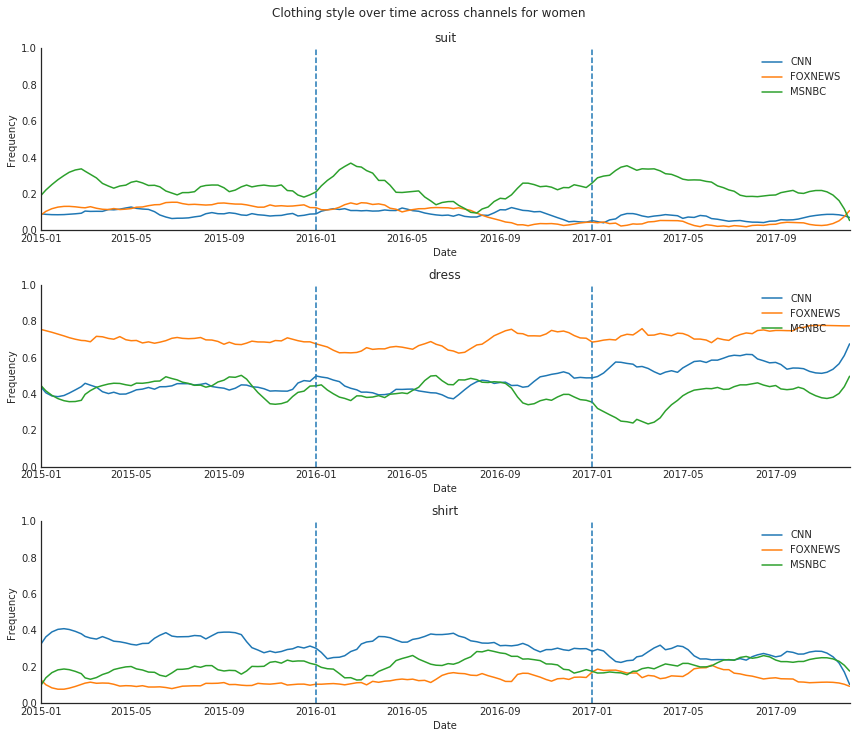

In [14]:
def clothing_network_plot(styles):
    plt.figure(figsize=(12, 10))
    plt.suptitle('Clothing style over time across channels for women', y=1.02)
    for plotidx, style in enumerate(styles):
        df = pickle.load(open('/app/data/clothing_style_{}_channel.pkl'.format(style), 'rb')).reset_index()
        year_dates = [df.date[48], df.date[96]]
        plt.subplot(len(styles), 1, plotidx+1)    
        ax = plt.gca()
        for network, col in NETWORK_COLORS:
            df.plot('date', network, ax=ax, color=col)
        ax.set_ylim(0, 1)
        ax.axvline(x=year_dates[0], linestyle='--')
        ax.axvline(x=year_dates[1], linestyle='--')
        ax.set_title(style)
        ax.set_xlabel('Date')
        ax.set_ylabel('Frequency')
        ax.legend(loc='upper right')
    plt.tight_layout()
    
clothing_network_plot(['suit', 'dress', 'shirt'])

The above graph shows _unnormalized_ clothing frequency for female hosts, e.g. an 0.8 dress score on the orange line means 80% of Fox female hosts wore dresses in that week. Men largely wear suits all the time, only choosing to vary their necktie preference, but women exhibit much greater variance in their clothing choices. Specifically, we can see that more women on Fox wear dresses than the other channels, whereas CNN prefers shirts and MSNBC prefers suits.

**TODO: Hair color/length comparison.**